<a href="https://colab.research.google.com/github/hasibulhshovo/COMP432/blob/main/lab9/lab_9_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Convolutional Neural Networks (CNNs) — Lab Notebook (Expanded Theory + CIFAR‑10 & MNIST)

**Course:** COMP-432  
**Topic:** Convolutional Neural Networks  
**Prepared by:** Teaching Assistant Team  

---

## Learning Goals
By the end of this lab, you will be able to:
1. Explain the intuition behind convolutions, kernels/filters, padding, stride, dilation, receptive fields, and pooling.
2. Use and derive output-size and parameter-count formulas for convolution and fully-connected layers.
3. Distinguish convolution vs cross‑correlation and understand why deep learning usually uses the latter.
4. Understand Batch Normalization and Dropout mathematically and practically.
5. Implement from‑scratch (forward) 1D & 2D convolution demos to build intuition.
6. Train 2D CNNs on CIFAR‑10 (color images) and MNIST (grayscale), with data augmentation on MNIST.
7. Run ablations: BatchNorm vs none, Dropout vs none, MaxPool vs stride‑2 convs.
8. Explore weight decay (L2) and learning‑rate schedules (StepLR, Cosine) in a mini hyper‑param lab.
9. Visualize filters, feature maps; plot loss/accuracy curves and confusion matrices.


## Part 0 — Theory & Math (Expanded)

### 0.1 Convolution vs Cross-Correlation
For a 2D input $x$ and kernel $k$, **cross-correlation** is:
$$
(y * x)[i,j] = \sum_{u,v} x[i+u, j+v]\; k[u,v].
$$
**True convolution** flips the kernel:
$$
(y \star x)[i,j] = \sum_{u,v} x[i-u, j-v]\; k[u,v].
$$
In CNNs, learnable kernels make the flip irrelevant—networks learn the right orientation.

---

### 0.2 Shapes (1D & 2D)
* **1D:** $\left(N, C, W\right)$; **2D:** $\left(N, C, H, W\right)$.
    * $N$: Batch Size, $C$: Channels, $H$: Height, $W$: Width.

---

### 0.3 Output Size
**1D (Output Width):** $$
\text{out}_W = \left\lfloor \frac{W + 2P - K}{S} \right\rfloor + 1.
$$
**2D (Output Height & Width):**
$$
\text{out}_H = \left\lfloor \frac{H + 2P_h - K_h}{S_h} \right\rfloor + 1, \quad \text{out}_W = \left\lfloor \frac{W + 2P_w - K_w}{S_w} \right\rfloor + 1.
$$
* $P$: Padding, $K$: Kernel Size, $S$: Stride.

---

### 0.4 Parameters
**1D:** $$
C_{\text{out}} \cdot C_{\text{in}} \cdot K + C_{\text{out}}.
$$
**2D:** $$
C_{\text{out}} \cdot C_{\text{in}} \cdot K_h \cdot K_w + C_{\text{out}}.
$$
* $C_{\text{in}}, C_{\text{out}}$: Input and Output Channels.

---

### 0.5 Receptive Field (RF)
**General (1D):**
$$
\text{RF}_1 = k_1, \quad \text{RF}_{i+1} = \text{RF}_i + (k_{i+1}-1)\prod_{j=1}^i s_j d_{i+1}.
$$
**Special (stride=1, dilation=1):** $$
\text{RF} = 1 + \sum_i (k_i-1).
$$
* $k$: kernel size, $s$: stride, $d$: dilation.

---

### 0.6 Padding / Stride / Dilation
* **Padding:** Preserves spatial size.
* **Stride:** Downsamples the output size.
* **Dilation:** Expands the Receptive Field (RF) without adding more parameters.

---

### 0.7 Pooling vs Stride-2 Convs
* **Pooling:** Parameter-free, adds local invariance.
* **Stride-2 Convs:** Learnable, can preserve more information.

---

### 0.8 BatchNorm (BN)
$$
\hat{x}_{nchw} = \frac{x_{nchw}-\mu_c}{\sqrt{\sigma_c^2+\epsilon}}, \quad y=\gamma_c\hat{x}+\beta_c.
$$
Stabilizes and speeds up learning by normalizing activations.

---

### 0.9 Dropout
* Randomly **zeroes activations** with probability $p$. (Inverted dropout scales remaining activations by $1/(1-p)$ at train time).

---

### 0.10 Weight Decay ($L_2$)
* Penalizes large weights; encourages simpler models and prevents overfitting.

---

### 0.11 Learning-Rate Schedules
* **StepLR, Cosine Annealing:** Reduce the learning rate over time; often improves convergence and generalization.

# Importing Libraries

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import random


## Part 1 — From‑Scratch Convolution Demos (Forward Only)

Minimal NumPy implementations for intuition. These are slow and only for demonstration; training uses PyTorch below.


In [ ]:
# Naive 1D convolution (forward-only). For intuition, not for training.
# This implementation demonstrates the basic concept of 1D convolution
# without relying on deep learning libraries like PyTorch or TensorFlow.
def conv1d_forward_naive(x, w, b=None, stride=1, padding=0):
    """
    Performs a simple 1D convolution operation.

    Parameters:
        x : np.ndarray of shape (C_in, W)
            Input feature map with C_in channels and width W.
        w : np.ndarray of shape (C_out, C_in, K)
            Convolution filters (kernels), each with C_in input channels
            and kernel size K. There are C_out output filters.
        b : np.ndarray of shape (C_out,), optional
            Bias for each output channel. If None, no bias is added.
        stride : int
            Step size for sliding the convolution window.
        padding : int
            Number of zero-padding elements added to both sides of the input.

    Returns:
        y : np.ndarray of shape (C_out, W_out)
            Output feature map after convolution.
    """

    # Unpack input and weight dimensions
    C_in, W = x.shape
    C_out, C_in_w, K = w.shape

    # Ensure the number of input channels matches between input and weights
    assert C_in == C_in_w, "Channel mismatch between input and weights"

    # Compute the output width using the standard convolution formula
    W_out = (W + 2 * padding - K) // stride + 1

    # Apply zero-padding along the width dimension
    # This ensures the filter can slide over the padded edges
    xp = np.pad(x, ((0, 0), (padding, padding)), mode='constant')

    # Initialize the output array with zeros
    y = np.zeros((C_out, W_out), dtype=np.float32)

    # Loop over each output channel
    for co in range(C_out):
        # For each position along the width of the output
        for i in range(W_out):
            s = i * stride          # Start index of the current window
            e = s + K               # End index (exclusive)
            patch = xp[:, s:e]      # Extract input patch of shape (C_in, K)
            # Perform element-wise multiplication and sum over all input channels and kernel positions
            y[co, i] = np.sum(patch * w[co])

        # Add bias if provided
        if b is not None:
            y[co] += b[co]

    return y


# Quick sanity test
np.random.seed(0)

# Random input: 2 input channels, width 10
x = np.random.randn(2, 10).astype(np.float32)

# Random filters: 3 output channels, 2 input channels per filter, kernel size 3
w = np.random.randn(3, 2, 3).astype(np.float32)

# Random bias for each output channel
b = np.random.randn(3).astype(np.float32)

# Perform convolution with stride=1 and padding=1
y = conv1d_forward_naive(x, w, b, stride=1, padding=1)

# Print input and output shapes to verify correctness
print("1D demo shapes:", x.shape, "->", y.shape)

1D demo shapes: (2, 10) -> (3, 10)


In [ ]:
# Naive 2D convolution (forward-only). For intuition, not for training.
# This is a simple implementation of a 2D convolution operation
# using pure NumPy — no deep learning frameworks involved.
# It is meant to illustrate the underlying concept of convolution,
# not to be used for efficient computation or training.
def conv2d_forward_naive(x, w, b=None, stride=1, padding=0):
    """
    Performs a naive 2D convolution operation (forward pass only).

    Parameters:
        x : np.ndarray of shape (C_in, H, W)
            Input feature map with C_in input channels and spatial dimensions (H, W).
        w : np.ndarray of shape (C_out, C_in, K_h, K_w)
            Set of convolution filters (kernels). Each output channel has one filter.
        b : np.ndarray of shape (C_out,), optional
            Bias term for each output channel. If None, no bias is added.
        stride : int
            The step size with which the filter moves across the input.
        padding : int
            The number of zero-padding pixels added to each side of the input
            (both height and width dimensions).

    Returns:
        y : np.ndarray of shape (C_out, H_out, W_out)
            The output feature map after applying convolution.
    """

    # Extract input and kernel dimensions
    C_in, H, W = x.shape
    C_out, C_in_w, K_h, K_w = w.shape

    # Check that the number of input channels matches between input and filters
    assert C_in == C_in_w, "Channel mismatch between input and filters"

    # Compute output spatial dimensions using the standard convolution formula
    H_out = (H + 2 * padding - K_h) // stride + 1
    W_out = (W + 2 * padding - K_w) // stride + 1

    # Apply zero-padding to the input across height and width
    # Padding adds a border of zeros so filters can cover edge regions
    xp = np.pad(x, ((0, 0), (padding, padding), (padding, padding)), mode='constant')

    # Initialize the output tensor (filled with zeros)
    y = np.zeros((C_out, H_out, W_out), dtype=np.float32)

    # Loop over each output channel (filter)
    for co in range(C_out):
        # Slide the filter across the height and width of the input
        for i in range(H_out):
            for j in range(W_out):
                # Compute the top-left corner (start indices) of the current patch
                hs, ws = i * stride, j * stride

                # Extract the corresponding patch from the padded input
                patch = xp[:, hs:hs + K_h, ws:ws + K_w]  # Shape: (C_in, K_h, K_w)

                # Perform element-wise multiplication and sum to get one output value
                y[co, i, j] = np.sum(patch * w[co])

        # Add bias term for this output channel (if provided)
        if b is not None:
            y[co] += b[co]

    return y


# Quick sanity test
np.random.seed(1)

# Example input: 1 input channel, 8×8 spatial dimensions
x2 = np.random.randn(1, 8, 8).astype(np.float32)

# Example filters: 4 output channels, 1 input channel, 3×3 kernels
w2 = np.random.randn(4, 1, 3, 3).astype(np.float32)

# Example bias: one per output channel
b2 = np.random.randn(4).astype(np.float32)

# Run convolution with stride=1 and padding=1 (to preserve spatial size)
y2 = conv2d_forward_naive(x2, w2, b2, stride=1, padding=1)

# Print input/output shapes to confirm expected dimensions
print("2D demo shapes:", x2.shape, "->", y2.shape)

2D demo shapes: (1, 8, 8) -> (4, 8, 8)



## Part 2 — CIFAR‑10 (Color 32×32) with Ablations

We train compact CNNs on CIFAR‑10 and compare: Baseline (pooling), +BatchNorm, +Dropout, Stride‑2 convs, Weight Decay, LR Schedules.


In [ ]:
# CIFAR-10 dataloaders with light augmentation
# This code sets up the CIFAR-10 dataset for use with PyTorch,
# applying simple data augmentations to the training set
# and loading the data into DataLoaders for easy batch processing.

# Select the device to run computations on: GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------------------------------------
# 1. Define data transformations
# ----------------------------------------------------------

# Transformations for the training dataset:
# - RandomHorizontalFlip: randomly flips images horizontally (data augmentation)
# - ToTensor: converts PIL images to PyTorch tensors (scales pixels to [0, 1])
cifar_train_tf = T.Compose([
    T.RandomHorizontalFlip(),
    T.ToTensor(),
])

# Transformations for the test dataset:
# - Only ToTensor, no augmentation (to ensure consistency during evaluation)
cifar_test_tf = T.Compose([
    T.ToTensor(),
])

# ----------------------------------------------------------
# 2. Load CIFAR-10 datasets
# ----------------------------------------------------------

# CIFAR-10 contains 60,000 32×32 color images in 10 classes (6,000 per class)
# - Training set: 50,000 images
# - Test set: 10,000 images
# Images are automatically downloaded to "./data" if not already present.

cifar_train = torchvision.datasets.CIFAR10(
    root="./data",           # Folder to store data
    train=True,              # Load training set
    download=True,           # Download if missing
    transform=cifar_train_tf # Apply training transforms
)

cifar_test = torchvision.datasets.CIFAR10(
    root="./data",           # Same folder
    train=False,             # Load test set
    download=True,           # Download if missing
    transform=cifar_test_tf  # Apply test transforms
)

# ----------------------------------------------------------
# 3. Create DataLoaders for batch loading
# ----------------------------------------------------------

# DataLoader helps:
# - Load data in batches
# - Shuffle training data for randomness
# - Use multiple workers for faster data loading (num_workers > 0)

train_loader_c = DataLoader(
    cifar_train,
    batch_size=128,  # Number of samples per batch
    shuffle=True,    # Shuffle for training
    num_workers=2    # Parallel data loading threads
)

test_loader_c = DataLoader(
    cifar_test,
    batch_size=512,  # Larger batch size (faster evaluation)
    shuffle=False,   # No shuffling for test set
    num_workers=2
)

# ----------------------------------------------------------
# 4. Miscellaneous setup
# ----------------------------------------------------------

# CIFAR-10 has 10 classes:
#  ['airplane', 'automobile', 'bird', 'cat', 'deer',
#   'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = 10

100%|██████████| 170M/170M [00:30<00:00, 5.68MB/s]


In [ ]:
# CNN builder with toggles for BN/Dropout/Stride-2
# This flexible CNN class allows toggling BatchNorm, Dropout, and Stride-2 convolutions
# to experiment with different architectures on the CIFAR-10 dataset.
class CIFARConvNet(nn.Module):
    def __init__(self, use_bn=False, use_dropout=False, stride2=False, p_drop=0.3):
        """
        Initialize a configurable CNN for CIFAR-10 classification.

        Parameters:
            use_bn (bool): If True, include Batch Normalization layers after convolutions.
            use_dropout (bool): If True, include Dropout in the fully connected head.
            stride2 (bool): If True, downsample using stride=2 convolutions instead of pooling.
            p_drop (float): Dropout probability (used if use_dropout=True).
        """
        super().__init__()

        # ----------------------------------------------------------
        # Define helper functions for building convolutional blocks
        # ----------------------------------------------------------

        def block(cin, cout, pool=True):
            """
            Standard convolutional block:
            Conv -> (BatchNorm) -> ReLU -> (MaxPool)

            Parameters:
                cin (int):  Input channel count.
                cout (int): Output channel count.
                pool (bool): Whether to include MaxPool2d(2) for downsampling.
            """
            layers = [nn.Conv2d(cin, cout, kernel_size=3, padding=1)]
            if use_bn:
                layers += [nn.BatchNorm2d(cout)]  # Optional BatchNorm layer
            layers += [nn.ReLU()]                 # Non-linearity
            if pool:
                layers += [nn.MaxPool2d(2)]       # Downsample by 2x
            return nn.Sequential(*layers)

        def block_s2(cin, cout):
            """
            Alternative convolutional block using stride=2 for downsampling:
            Conv(stride=2) -> (BatchNorm) -> ReLU
            """
            layers = [nn.Conv2d(cin, cout, kernel_size=3, stride=2, padding=1)]
            if use_bn:
                layers += [nn.BatchNorm2d(cout)]
            layers += [nn.ReLU()]
            return nn.Sequential(*layers)

        # ----------------------------------------------------------
        # 1. Feature extractor (convolutional backbone)
        # ----------------------------------------------------------

        # If stride2=True, use stride-2 convolutions for spatial downsampling
        # Otherwise, use MaxPooling layers after normal convolutions
        if stride2:
            self.features = nn.Sequential(
                block_s2(3, 32),   # Output: 32×16×16
                block_s2(32, 64),  # Output: 64×8×8
                block_s2(64, 128), # Output: 128×4×4
            )
        else:
            self.features = nn.Sequential(
                block(3, 32, pool=True),   # Conv + MaxPool -> 32×16×16
                block(32, 64, pool=True),  # Conv + MaxPool -> 64×8×8
                block(64, 128, pool=True), # Conv + MaxPool -> 128×4×4
            )

        # ----------------------------------------------------------
        # 2. Classification head (fully connected layers)
        # ----------------------------------------------------------

        # Flatten -> Linear -> ReLU -> (Dropout) -> Linear(output)
        head = [
            nn.Flatten(),                        # Flatten 4D tensor to 2D
            nn.Linear(128 * 4 * 4, 256),         # Fully connected hidden layer
            nn.ReLU()                            # Activation
        ]

        if use_dropout:
            head += [nn.Dropout(p_drop)]         # Optional dropout for regularization

        # Final output layer: 10 classes for CIFAR-10
        head += [nn.Linear(256, num_classes)]

        # Combine all head layers into a Sequential container
        self.classifier = nn.Sequential(*head)

    # ----------------------------------------------------------
    # 3. Forward pass
    # ----------------------------------------------------------
    def forward(self, x):
        """
        Defines the forward pass of the network.
        Input x: shape (batch_size, 3, 32, 32)
        """
        x = self.features(x)      # Extract spatial features
        x = self.classifier(x)    # Classify into one of the 10 classes
        return x

In [ ]:
# Training/evaluation helper with weight decay and scheduler toggles
# This utility function provides a simple yet flexible training loop for
# CIFAR-10 experiments, allowing you to toggle between schedulers, add
# weight decay, and track both training/test accuracy over epochs.
def train_eval(model, train_loader, test_loader, epochs=3, lr=1e-3, weight_decay=0.0, scheduler_type=None):
    """
    Train and evaluate a PyTorch model with optional learning rate scheduler.

    Parameters:
        model (nn.Module):        The neural network model to train.
        train_loader (DataLoader): DataLoader for the training set.
        test_loader (DataLoader):  DataLoader for the test/validation set.
        epochs (int):             Number of training epochs.
        lr (float):               Initial learning rate.
        weight_decay (float):     L2 regularization strength (for Adam optimizer).
        scheduler_type (str):     Type of LR scheduler ("StepLR", "Cosine", or None).

    Returns:
        losses (list):   Average training loss per epoch.
        tr_accs (list):  Training accuracy per epoch.
        te_accs (list):  Test accuracy per epoch.
        model (nn.Module): The trained model.
    """
    # Move model to GPU if available
    model = model.to(device)

    # Define loss function: CrossEntropyLoss for classification tasks
    crit = nn.CrossEntropyLoss()

    # Adam optimizer with optional weight decay for regularization
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # ----------------------------------------------------------
    # Optional learning rate scheduler
    # ----------------------------------------------------------
    if scheduler_type == "StepLR":
        # StepLR: halves LR after every (epochs // 2) epochs
        sched = torch.optim.lr_scheduler.StepLR(opt, step_size=max(1, epochs // 2), gamma=0.5)
    elif scheduler_type == "Cosine":
        # CosineAnnealingLR: gradually decreases LR following a cosine curve
        sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)
    else:
        # No scheduler
        sched = None

    # Lists to store training progress
    losses, tr_accs, te_accs = [], [], []

    # ----------------------------------------------------------
    # Main training loop
    # ----------------------------------------------------------
    for ep in range(1, epochs + 1):
        model.train()       # Enable training mode (activates dropout/batchnorm updates)
        total = 0           # Total number of samples processed
        correct = 0         # Number of correctly classified samples
        ep_loss = 0.0       # Cumulative loss for the epoch

        # ----------------------------
        # Training phase
        # ----------------------------
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)       # Move batch to GPU
            opt.zero_grad()                             # Reset gradients
            out = model(xb)                             # Forward pass
            loss = crit(out, yb)                        # Compute loss
            loss.backward()                             # Backpropagate
            opt.step()                                  # Update weights

            # Update metrics
            ep_loss += loss.item() * xb.size(0)         # Accumulate total loss
            correct += (out.argmax(1) == yb).sum().item() # Count correct predictions
            total += yb.size(0)                         # Track total samples

        # Record average training loss and accuracy
        losses.append(ep_loss / total)
        tr_accs.append(correct / total)

        # ----------------------------
        # Evaluation phase
        # ----------------------------
        model.eval()            # Disable dropout/batchnorm updates
        te_total = 0            # Total test samples
        te_correct = 0          # Correct test predictions

        with torch.no_grad():   # Disable gradient computation for efficiency
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb).argmax(1)
                te_correct += (preds == yb).sum().item()
                te_total += yb.size(0)

        # Record test accuracy
        te_accs.append(te_correct / te_total)

        # Print epoch summary
        print(f"Epoch {ep}: "
              f"loss={losses[-1]:.4f} "
              f"train={tr_accs[-1]*100:.2f}% "
              f"test={te_accs[-1]*100:.2f}%")

        # Step scheduler if applicable
        if sched is not None:
            sched.step()

    # Return training history and trained model
    return losses, tr_accs, te_accs, model

In [ ]:
# Run short ablations (few epochs for class)
# ----------------------------------------------------------
# This section runs quick training experiments (ablations)
# to compare different CNN configurations and training options
# such as BatchNorm, Dropout, Stride-2 convolutions, weight decay,
# and learning rate schedulers.
# ----------------------------------------------------------

epochs = 3  # Small number of epochs for quick comparison (not full training)

# ----------------------------------------------------------
# 1️⃣ Base model — no BatchNorm, no Dropout, no Stride-2
# ----------------------------------------------------------
m_base = CIFARConvNet(use_bn=False, use_dropout=False, stride2=False)
L_b, Tr_b, Te_b, m_base = train_eval(
    m_base, train_loader_c, test_loader_c, epochs=epochs
)
print("====================")

# ----------------------------------------------------------
# 2️⃣ With Batch Normalization — improves training stability
# ----------------------------------------------------------
m_bn = CIFARConvNet(use_bn=True, use_dropout=False, stride2=False)
L_bn, Tr_bn, Te_bn, m_bn = train_eval(
    m_bn, train_loader_c, test_loader_c, epochs=epochs
)
print("====================")

# ----------------------------------------------------------
# 3️⃣ With Dropout — helps reduce overfitting
# ----------------------------------------------------------
m_do = CIFARConvNet(use_bn=False, use_dropout=True, stride2=False, p_drop=0.4)
L_do, Tr_do, Te_do, m_do = train_eval(
    m_do, train_loader_c, test_loader_c, epochs=epochs
)
print("====================")

# ----------------------------------------------------------
# 4️⃣ Using Stride-2 convolutions instead of MaxPooling
#     - Reduces spatial resolution using stride=2 convs
#     - Sometimes improves feature efficiency
# ----------------------------------------------------------
m_s2 = CIFARConvNet(use_bn=True, use_dropout=False, stride2=True)
L_s2, Tr_s2, Te_s2, m_s2 = train_eval(
    m_s2, train_loader_c, test_loader_c, epochs=epochs
)
print("====================")

# ----------------------------------------------------------
# 5️⃣ With Weight Decay — adds L2 regularization on weights
#     - Penalizes large weights to help generalization
# ----------------------------------------------------------
m_wd = CIFARConvNet(use_bn=True, use_dropout=True, stride2=False)
L_wd, Tr_wd, Te_wd, m_wd = train_eval(
    m_wd, train_loader_c, test_loader_c, epochs=epochs, weight_decay=1e-4
)
print("====================")

# ----------------------------------------------------------
# 6️⃣ With Learning Rate Scheduler — StepLR
#     - Halves learning rate halfway through training
#     - Can help convergence in longer runs

Epoch 1: loss=1.6092 train=40.81% test=52.05%
Epoch 2: loss=1.2172 train=56.38% test=60.27%
Epoch 3: loss=1.0393 train=63.12% test=65.33%
Epoch 1: loss=1.2457 train=55.13% test=62.52%
Epoch 2: loss=0.8612 train=69.80% test=65.78%
Epoch 3: loss=0.7351 train=74.34% test=73.56%
Epoch 1: loss=1.6564 train=39.32% test=51.67%
Epoch 2: loss=1.2853 train=53.98% test=61.24%
Epoch 3: loss=1.1224 train=60.26% test=65.45%
Epoch 1: loss=1.3205 train=52.43% test=61.12%
Epoch 2: loss=0.9715 train=65.44% test=56.50%
Epoch 3: loss=0.8199 train=70.92% test=67.41%
Epoch 1: loss=1.2944 train=53.14% test=62.19%
Epoch 2: loss=0.9349 train=67.27% test=70.29%
Epoch 3: loss=0.8175 train=71.12% test=63.84%
Epoch 1: loss=1.2935 train=53.53% test=59.22%
Epoch 2: loss=0.9026 train=68.20% test=70.64%
Epoch 3: loss=0.7811 train=72.64% test=74.01%


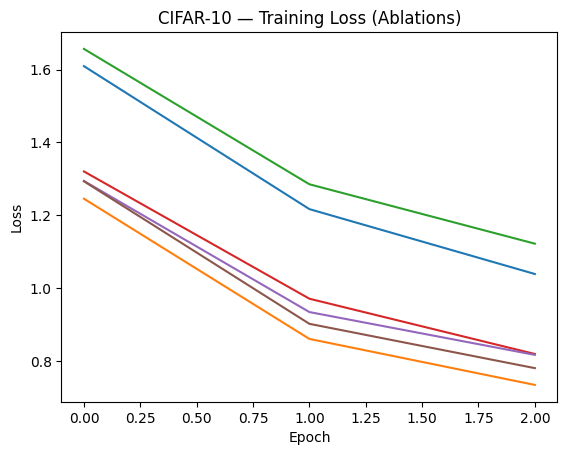

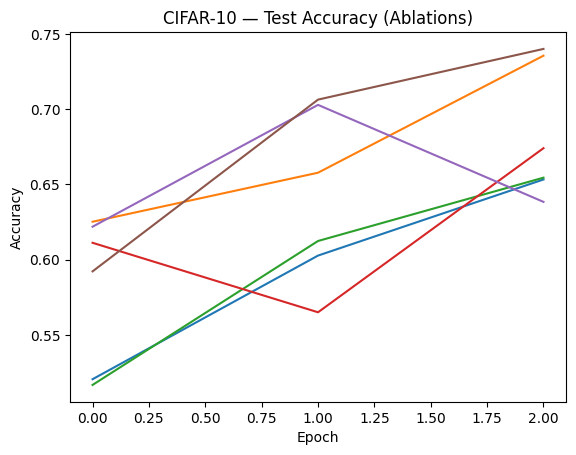

In [ ]:
# Plot curves (each metric in its own figure; default colors)
# ----------------------------------------------------------
# This code visualizes the results from the ablation experiments.
# It plots:
#   (1) Training loss curves
#   (2) Test accuracy curves
# for all model variants side-by-side to compare their performance.
# ----------------------------------------------------------

# ----------------------------------------------------------
# 1️⃣ Plot training loss across ablation runs
# ----------------------------------------------------------
plt.figure(figsize=(6, 4))
for L in [L_b, L_bn, L_do, L_s2, L_wd, L_lr]:
    plt.plot(L)  # Default line colors assigned automatically

plt.title("CIFAR-10 — Training Loss (Ablations)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Base", "BatchNorm", "Dropout", "Stride-2", "Weight Decay", "StepLR"])
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# ----------------------------------------------------------
# 2️⃣ Plot test accuracy across ablation runs
# ----------------------------------------------------------
plt.figure(figsize=(6, 4))
for A in [Te_b, Te_bn, Te_do, Te_s2, Te_wd, Te_lr]:
    plt.plot(A)

plt.title("CIFAR-10 — Test Accuracy (Ablations)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Base", "BatchNorm", "Dropout", "Stride-2", "Weight Decay", "StepLR"])
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

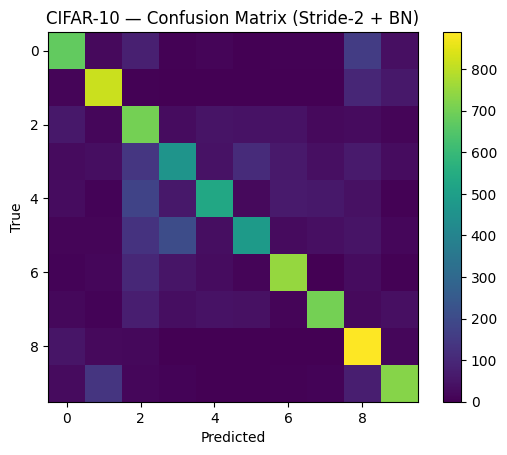

In [ ]:
# Confusion matrix for an example model (stride-2 + BN)
# ----------------------------------------------------------
# This section computes and visualizes the confusion matrix
# for one of the trained CNN models — here, the "Stride-2 + BatchNorm" variant.
# It shows how well the model performs per class, and where it tends to make mistakes.
# ----------------------------------------------------------

def confusion_matrix_for(model, loader):
    """
    Compute the confusion matrix for a given model and data loader.

    Parameters:
        model (nn.Module): The trained CNN model to evaluate.
        loader (DataLoader): The DataLoader for the evaluation dataset.

    Returns:
        cm (ndarray): The confusion matrix (shape: num_classes x num_classes)
                      where rows correspond to true labels and columns to predictions.
    """
    model.eval()        # Switch to evaluation mode (disables dropout/batchnorm updates)
    ys, ps = [], []     # Lists to collect true labels and predictions

    # Disable gradient calculation for faster inference
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)                  # Move input batch to GPU/CPU
            preds = model(xb).argmax(1)         # Get predicted class indices
            ys += yb.numpy().tolist()           # Collect true labels
            ps += preds.cpu().numpy().tolist()  # Collect predictions (move to CPU)

    # Use sklearn's confusion_matrix function to compute results
    return confusion_matrix(ys, ps)

# ----------------------------------------------------------
# Compute and visualize confusion matrix for the stride-2 model
# ----------------------------------------------------------
cm = confusion_matrix_for(m_s2, test_loader_c)

plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)  # Use blue color map for clarity
plt.title("CIFAR-10 — Confusion Matrix (Stride-2 + BN)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.colorbar()

# Optional: label ticks for CIFAR-10 classes
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]
plt.xticks(ticks=np.arange(10), labels=class_names, rotation=45, ha="right")
plt.yticks(ticks=np.arange(10), labels=class_names)
plt.tight_layout()
plt.show()

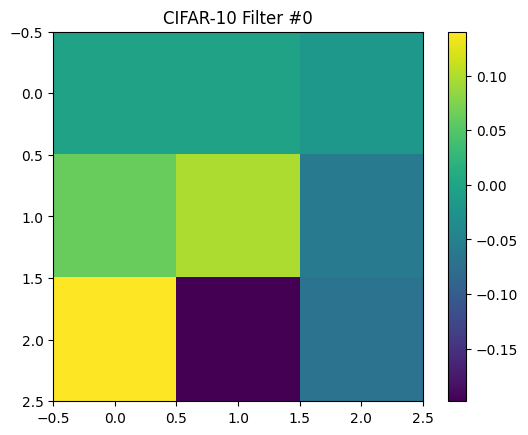

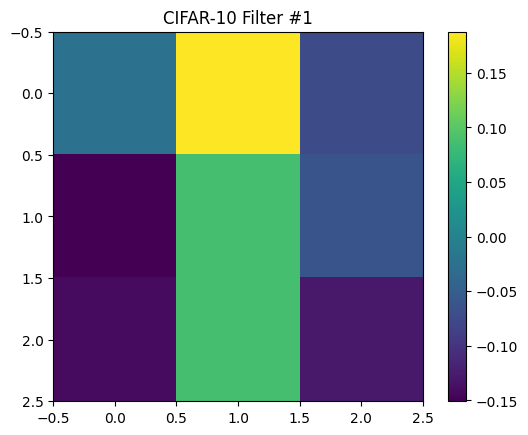

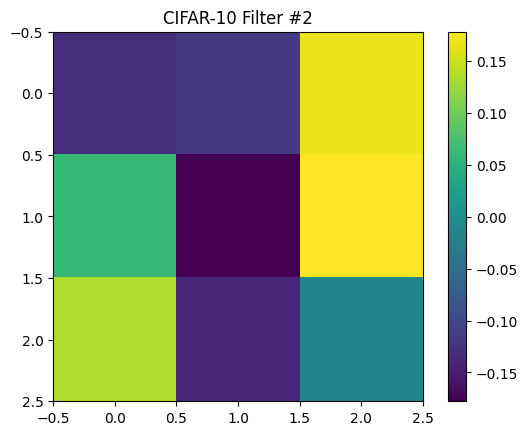

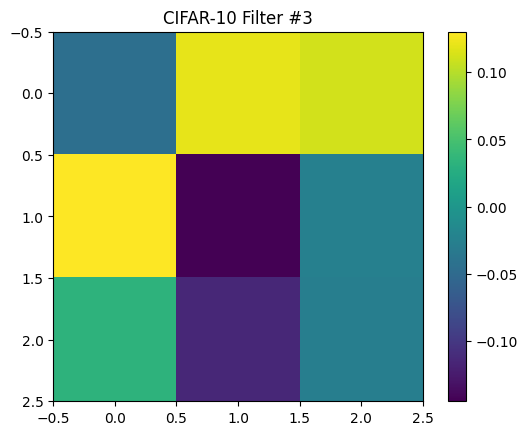

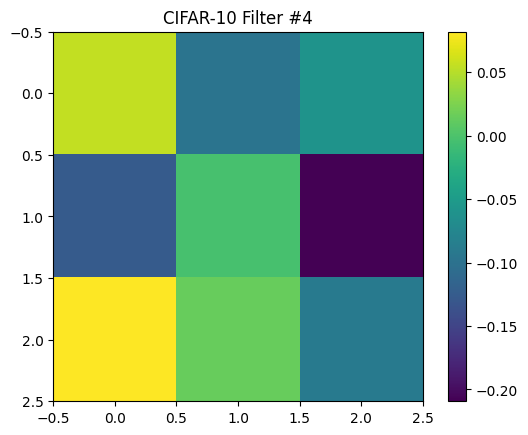

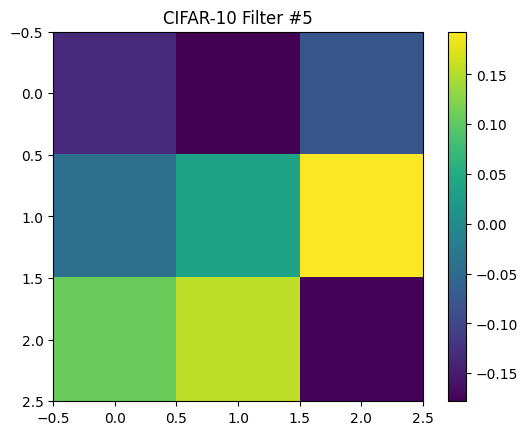

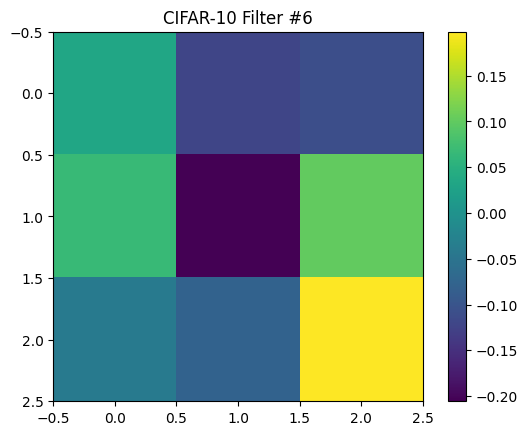

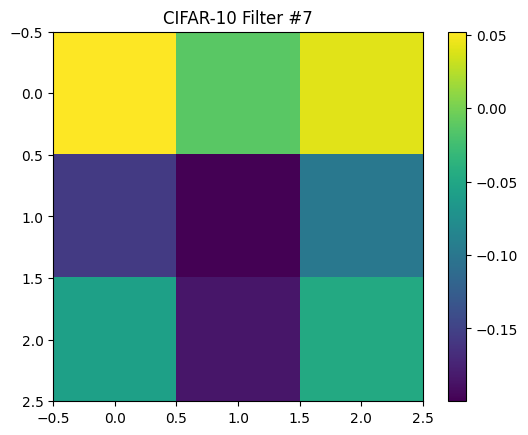

In [ ]:
# Visualize first conv filters (first channel) for the BN model
# --------------------------------------------------------------
# This code visualizes the learned filters (weights) from the first
# convolutional layer of the BatchNorm-enabled CNN.
# These filters show what low-level patterns (edges, colors, textures)
# the network has learned from the CIFAR-10 dataset.
# --------------------------------------------------------------

# ----------------------------------------------------------
# 1️⃣ Locate the first Conv2d layer in the model
# ----------------------------------------------------------
first_conv = None
for mod in m_bn.modules():
    if isinstance(mod, nn.Conv2d):
        first_conv = mod
        break  # Stop after finding the first convolution layer

# ----------------------------------------------------------
# 2️⃣ Extract and visualize filter weights (if found)
# ----------------------------------------------------------
if first_conv is not None:
    # Get the convolution weight tensor: shape (C_out, C_in, Kh, Kw)
    # Example for CIFAR: (32, 3, 3, 3) → 32 filters, 3 input channels (RGB)
    W = first_conv.weight.detach().cpu().numpy()

    # Visualize up to 8 filters from the first input channel (usually red)
    for i in range(min(8, W.shape[0])):
        plt.figure(figsize=(3, 3))
        plt.imshow(W[i, 0], interpolation='nearest', cmap='viridis')
        plt.title(f"CIFAR-10 — Filter #{i} (1st Conv, Channel 0)")
        plt.colorbar(label="Weight Value")
        plt.axis("off")
        plt.show()
else:
    print("No Conv2d layer found in the model.")


## Part 3 — MNIST with Small Random Shifts; Pooling vs Stride‑2

We apply small random translations to MNIST to observe generalization; compare pooling vs stride‑2.


In [ ]:
# ----------------------------------------------------------
# MNIST dataloaders with light augmentation
# ----------------------------------------------------------
# This code sets up PyTorch DataLoaders for the MNIST dataset.
# It applies simple transformations to the training set (random translations)
# and converts images to tensors. The test set only gets converted to tensors.
# ----------------------------------------------------------

# ----------------------------------------------------------
# 1️⃣ Define transformations
# ----------------------------------------------------------
mnist_train_tf = T.Compose([
    T.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Randomly shift image up to 10% in x/y
    T.ToTensor()                                      # Convert PIL image to tensor (C,H,W), normalize to [0,1]
])

mnist_test_tf = T.Compose([
    T.ToTensor()  # Test set is not augmented; just convert to tensor
])

# ----------------------------------------------------------
# 2️⃣ Load datasets
# ----------------------------------------------------------
mnist_train = torchvision.datasets.MNIST(
    root="./data",       # Directory to store/download MNIST
    train=True,          # Load training set
    download=True,       # Download if not already present
    transform=mnist_train_tf
)

mnist_test = torchvision.datasets.MNIST(
    root="./data",
    train=False,         # Load test set
    download=True,
    transform=mnist_test_tf
)

# ----------------------------------------------------------
# 3️⃣ Create DataLoaders
# ----------------------------------------------------------
train_loader_m = DataLoader(
    mnist_train,
    batch_size=128,      # Number of samples per batch
    shuffle=True         # Shuffle dataset at every epoch
)

test_loader_m = DataLoader(
    mnist_test,
    batch_size=512,      # Larger batch size for faster evaluation
    shuffle=False         # No shuffle needed for test set
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 63.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.74MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.37MB/s]


[MNIST] Epoch 1: loss=0.3273 train=89.79% test=97.98%
[MNIST] Epoch 2: loss=0.1251 train=96.25% test=98.22%
[MNIST] Epoch 3: loss=0.0965 train=97.08% test=98.60%
[MNIST](s2) Epoch 1: loss=0.3947 train=87.69% test=97.94%
[MNIST](s2) Epoch 2: loss=0.1391 train=95.77% test=98.46%
[MNIST](s2) Epoch 3: loss=0.1077 train=96.75% test=98.60%


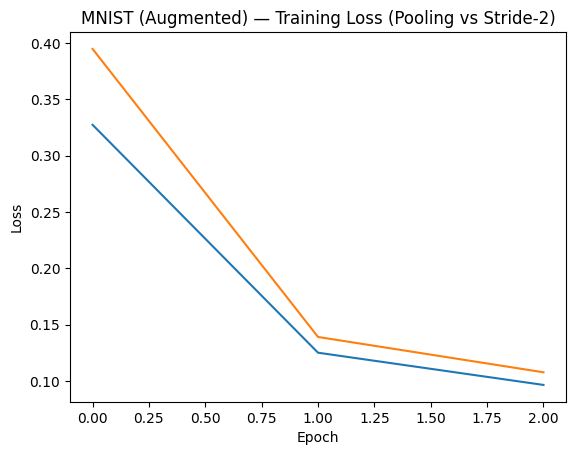

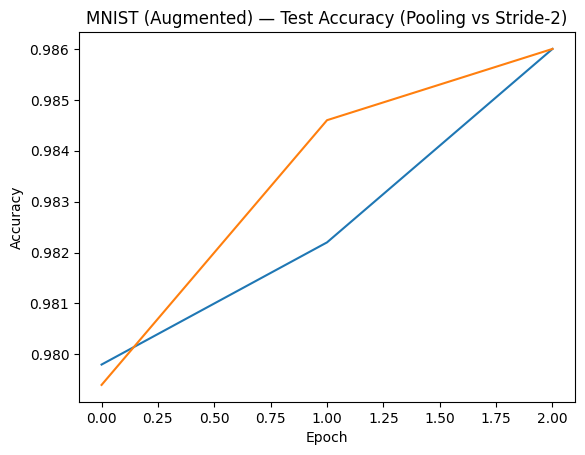

In [ ]:
# ----------------------------------------------------------
# 1️⃣ Define a small CNN for MNIST
# ----------------------------------------------------------
class MNISTConv(nn.Module):
    def __init__(self, use_bn=True, use_dropout=True, stride2=False):
        super().__init__()

        # -----------------------------------
        # Convolutional block with optional pooling
        # -----------------------------------
        def blk(cin, cout, pool=True):
            L = [nn.Conv2d(cin, cout, 3, padding=1)]  # 3x3 conv, same padding
            if use_bn: L += [nn.BatchNorm2d(cout)]    # optional batch norm
            L += [nn.ReLU()]                           # activation
            if pool: L += [nn.MaxPool2d(2)]           # optional 2x2 max pooling
            return nn.Sequential(*L)

        # -----------------------------------
        # Convolutional block with stride-2 downsampling
        # -----------------------------------
        def blk_s2(cin, cout):
            L = [nn.Conv2d(cin, cout, 3, stride=2, padding=1)]  # stride-2 conv
            if use_bn: L += [nn.BatchNorm2d(cout)]
            L += [nn.ReLU()]
            return nn.Sequential(*L)

        # Feature extractor: 2 convolutional layers
        if stride2:
            self.features = nn.Sequential(
                blk_s2(1, 16),   # input channel 1 (grayscale), output 16
                blk_s2(16, 32)
            )
        else:
            self.features = nn.Sequential(
                blk(1, 16, pool=True),
                blk(16, 32, pool=True)
            )

        # Fully connected head
        head = [nn.Flatten(), nn.Linear(32*7*7, 128), nn.ReLU()]  # MNIST 28x28 → after 2x2 pooling: 7x7
        if use_dropout:
            head += [nn.Dropout(0.3)]
        head += [nn.Linear(128, 10)]  # 10 classes
        self.classifier = nn.Sequential(*head)

    def forward(self, x):
        return self.classifier(self.features(x))

# ----------------------------------------------------------
# 2️⃣ Training & evaluation loop for MNIST
# ----------------------------------------------------------
def run_mnist(epochs=3, stride2=False):
    model = MNISTConv(use_bn=True, use_dropout=True, stride2=stride2).to(device)
    crit = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)

    Ls, Tr, Te = [], [], []  # store loss, train acc, test acc

    for ep in range(epochs):
        # ---------- Training ----------
        model.train()
        tot, cor, epL = 0, 0, 0.0
        for xb, yb in train_loader_m:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            out = model(xb)
            loss = crit(out, yb)
            loss.backward()
            opt.step()
            epL += loss.item()*xb.size(0)
            cor += (out.argmax(1)==yb).sum().item()
            tot += yb.size(0)

        Ls.append(epL/tot)
        Tr.append(cor/tot)

        # ---------- Evaluation ----------
        model.eval()
        te_t, te_c = 0, 0
        with torch.no_grad():
            for xb, yb in test_loader_m:
                xb, yb = xb.to(device), yb.to(device)
                te_c += (model(xb).argmax(1)==yb).sum().item()
                te_t += yb.size(0)
        Te.append(te_c/te_t)

        print(f"[MNIST]{'(s2)' if stride2 else ''} Epoch {ep+1}: "
              f"loss={Ls[-1]:.4f} train={Tr[-1]*100:.2f}% test={Te[-1]*100:.2f}%")

    return Ls, Tr, Te

# ----------------------------------------------------------
# 3️⃣ Run short ablation: pooling vs stride-2
# ----------------------------------------------------------
L_m_pool, Tr_m_pool, Te_m_pool = run_mnist(epochs=3, stride2=False)
L_m_s2,   Tr_m_s2,   Te_m_s2   = run_mnist(epochs=3, stride2=True)

# ----------------------------------------------------------
# 4️⃣ Plot training loss curves
# ----------------------------------------------------------
plt.figure()
plt.plot(L_m_pool, label="Pooling")
plt.plot(L_m_s2, label="Stride-2")
plt.title("MNIST (Augmented) — Training Loss (Pooling vs Stride‑2)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# ----------------------------------------------------------
# 5️⃣ Plot test accuracy curves
# ----------------------------------------------------------
plt.figure()
plt.plot(Te_m_pool, label="Pooling")
plt.plot(Te_m_s2, label="Stride-2")
plt.title("MNIST (Augmented) — Test Accuracy (Pooling vs Stride‑2)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


## Part 4 — Reflections & Deliverables

- BN often stabilizes/accelerates training; Dropout reduces overfitting (watch train vs test gap).
- Stride‑2 vs Pooling: trade off invariance vs learnable downsampling.
- Augmentation: small shifts usually help generalization on MNIST.
- Hyper‑params: try different weight decay and LR schedules; observe stability/accuracy.

**Submit:** curves (loss/accuracy), at least one CIFAR‑10 confusion matrix, and filter snapshots, plus a short discussion.



## Appendix — Utilities


In [ ]:
# Reproducibility helper
def set_seed(seed=42):
    """
    Set random seeds for Python, NumPy, and PyTorch to ensure reproducible results.

    Args:
        seed (int): The seed value to use (default=42).
    """
    random.seed(seed)            # Set Python random module seed
    np.random.seed(seed)         # Set NumPy random seed
    torch.manual_seed(seed)      # Set PyTorch CPU seed
    if torch.cuda.is_available():
        torch.manual_seed_all(seed)  # Set PyTorch GPU seed for all devices

    # Optional: enforce deterministic behavior for cuDNN (may slow down training)
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False

# Set seed to 42 for reproducibility
set_seed(42)
print("Seed set to 42")

Seed set to 42
